In [35]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

In [36]:
data = pd.read_csv('PressureDistributionData.csv', sep=',')

lines_case = 4800
test_samples = 30

indices = np.arange(len(data))
data['group_id'] = indices // lines_case

all_group_ids = data['group_id'].unique()

data_train_id, data_test_id = train_test_split(all_group_ids, test_size=test_samples, random_state=42)

data_train = data[data['group_id'].isin(data_train_id)]
data_test = data[data['group_id'].isin(data_test_id)]

data_train = data_train.drop(columns=['group_id']).reset_index(drop=True)
data_test = data_test.drop(columns=['group_id']).reset_index(drop=True)

data_train.head()

,Re,AoA,y,x,Surf.,cp
0,130809.301414,1,0.0201,1.00000,1,0.13037
1,130809.301414,1,0.0201,0.99318,1,0.12049
2,130809.301414,1,0.0201,0.98170,1,0.10031
3,130809.301414,1,0.0201,0.96863,1,0.07868
4,130809.301414,1,0.0201,0.95406,1,0.05566


In [37]:
nome_coluna = 'Surf.'

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(data_train[[nome_coluna]])
encoded_cols_treino = encoder.transform(data_train[[nome_coluna]])
encoded_cols_teste = encoder.transform(data_test[[nome_coluna]])
data_treino_encoded = pd.DataFrame(encoded_cols_treino, columns=encoder.get_feature_names_out([nome_coluna]))
data_teste_encoded = pd.DataFrame(encoded_cols_teste, columns=encoder.get_feature_names_out([nome_coluna]))

data_train = pd.concat([data_train, data_treino_encoded], axis=1)
data_test = pd.concat([data_test, data_teste_encoded], axis=1)

data_train = data_train.drop(columns=[nome_coluna])
data_test = data_test.drop(columns=[nome_coluna])

data_train.head()

,Re,AoA,y,x,cp,Surf._-1,Surf._1
0,130809.301414,1,0.0201,1.00000,0.13037,0.0,1.0
1,130809.301414,1,0.0201,0.99318,0.12049,0.0,1.0
2,130809.301414,1,0.0201,0.98170,0.10031,0.0,1.0
3,130809.301414,1,0.0201,0.96863,0.07868,0.0,1.0
4,130809.301414,1,0.0201,0.95406,0.05566,0.0,1.0


In [39]:
cols_para_minmax = ['Re', 'AoA', 'y', 'x']
scaler_minmax = MinMaxScaler()
scaler_minmax.fit(data_train[cols_para_minmax])
data_train[cols_para_minmax] = scaler_minmax.transform(data_train[cols_para_minmax])
data_test[cols_para_minmax] = scaler_minmax.transform(data_test[cols_para_minmax])

cols_para_maxabs = ['cp']
scaler_maxabs = MaxAbsScaler()
scaler_maxabs.fit(data_train[cols_para_maxabs])
data_train[cols_para_maxabs] = scaler_maxabs.transform(data_train[cols_para_maxabs])
data_test[cols_para_maxabs] = scaler_maxabs.transform(data_test[cols_para_maxabs])

data_train.head()

,Re,AoA,y,x,cp,Surf._-1,Surf._1
0,0.0,0.1,0.0,1.000000,0.040223,0.0,1.0
1,0.0,0.1,0.0,0.993180,0.037175,0.0,1.0
2,0.0,0.1,0.0,0.981700,0.030949,0.0,1.0
3,0.0,0.1,0.0,0.968629,0.024275,0.0,1.0
4,0.0,0.1,0.0,0.954059,0.017173,0.0,1.0


In [41]:
coluna_target = 'cp'

Y_train = data_train[coluna_target]
Y_test = data_test[coluna_target]
X_train = data_train.drop(columns=[coluna_target])
X_test = data_test.drop(columns=[coluna_target])

X_train.head()

,Re,AoA,y,x,Surf._-1,Surf._1
0,0.0,0.1,0.0,1.000000,0.0,1.0
1,0.0,0.1,0.0,0.993180,0.0,1.0
2,0.0,0.1,0.0,0.981700,0.0,1.0
3,0.0,0.1,0.0,0.968629,0.0,1.0
4,0.0,0.1,0.0,0.954059,0.0,1.0


In [45]:
model = Sequential([
    Input(shape=(6,)),   # substitui input_dim=3
    Dense(64, activation='tanh'),
    #BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dense(1, activation='linear')  # output
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)
]

history = model.fit(
    X_train, Y_train,
    validation_split=0.25,
    epochs=500,
    batch_size=5,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/500
65520/65520 ━━━━━━━━━━━━━━━━━━━━ 78s 1ms/step - loss: 0.0043 - mae: 0.0411 - val_loss: 0.0016 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/500
65520/65520 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step - loss: 0.0015 - mae: 0.0273 - val_loss: 7.5033e-04 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 3/500
65520/65520 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - loss: 0.0014 - mae: 0.0257 - val_loss: 8.3787e-04 - val_mae: 0.0203 - learning_rate: 0.0010
Epoch 4/500
65520/65520 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0011 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 5/500
65520/65520 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - loss: 0.0012 - mae: 0.0237 - val_loss: 0.0013 - val_mae: 0.0255 - learning_rate: 0.0010
Epoch 6/500
65520/65520 ━━━━━━━━━━━━━━━━━━━━ 79s 1ms/step - loss: 0.0011 - mae: 0.0234 - val_loss: 8.8297e-04 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 7/500
65520/65520 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 0

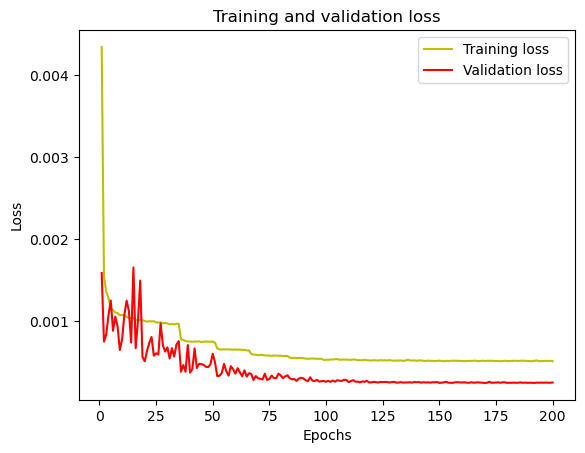

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
loss, mae = model.evaluate(X_test, Y_test, verbose=1)
print(f"Erro médio absoluto no teste: {mae:.4f}")

4500/4500 ━━━━━━━━━━━━━━━━━━━━ 3s 713us/step - loss: 2.7211e-04 - mae: 0.0113
Erro médio absoluto no teste: 0.0113


In [49]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred)

print(f"MAE  (Erro Absoluto Médio): {mae:.4f}")
print(f"MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
print(f"R²   (Coeficiente de Determinação): {r2:.4f}")

4500/4500 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step
MAE  (Erro Absoluto Médio): 0.0113
MSE  (Erro Quadrático Médio): 0.0003
RMSE (Raiz do Erro Quadrático Médio): 0.0165
R²   (Coeficiente de Determinação): 0.9938


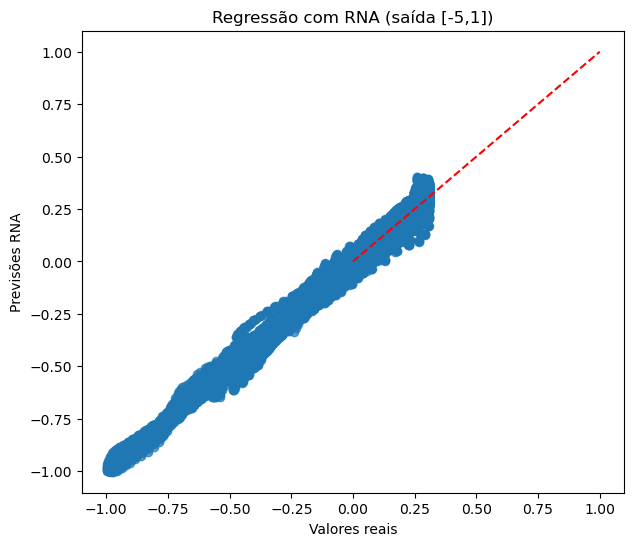

In [50]:
plt.figure(figsize=(7,6))
plt.scatter(Y_test, y_pred, alpha=0.7)
plt.xlabel("Valores reais")
plt.ylabel("Previsões RNA")
plt.title("Regressão com RNA (saída [-5,1])")
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [66]:
y_pred_unscaled = scaler_maxabs.inverse_transform(y_pred)

predictions = pd.DataFrame(y_pred_unscaled, columns=['Predictions'])

predictions.to_csv('predictions.csv', index=False)


data_test_unscaled = data_test.copy()
data_test_unscaled[['Re', 'AoA', 'y', 'x']] = scaler_minmax.inverse_transform(data_test_unscaled[['Re', 'AoA', 'y', 'x']])
data_test_unscaled[['cp']] = scaler_maxabs.inverse_transform(data_test_unscaled[['cp']])
data_test_unscaled.to_csv('data_test.csv', index=False)

y_pred

array([[0.03110042],
       [0.02886905],
       [0.02510694],
       ...,
       [0.03258635],
       [0.03697269],
       [0.0396359 ]], dtype=float32)

In [57]:
model.save('trained_model.keras')